In [1]:
pip list | grep torch

segmentation_models_pytorch   0.5.0
torch                         2.9.0
torchvision                   0.24.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# !pip install openslide-python openslide-bin matplotlib scikit-image scikit-learn Pillow shapely pandas opencv-python-headless torch torchvision spectral
# !pip install segmentation-models-pytorch albumentations
# !pip install -U ipywidgets tqdm

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time, math, cv2
from PIL import Image
import spectral
import tifffile
import json, shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as T
from sklearn.metrics import roc_auc_score, accuracy_score
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

from glob import glob
from shapely.geometry import Polygon, Point

In [4]:
os.getcwd()

'/home/kumar65'

In [5]:
base_dir = "HNSCC"

### Reading and storing HNSCC file paths

In [6]:
def get_case_paths(base_dir):
    cases = []
    for outer in sorted(os.listdir(base_dir)):
        if not outer.startswith("RS_"): # outer RS_
            continue

        inner = os.path.join(base_dir, outer)
        if not os.path.isdir(inner):
            continue

        aligned_path = os.path.join(inner, outer, "aligned")
        if not os.path.exists(aligned_path):
            print(f"WARNING: Missing aligned folder for {outer}")
            continue

        label_path = os.path.join(inner, outer, "PixelLabelData")
        if not os.path.exists(label_path):
            print(f"WARNING: Missing PixelLabelData folder for {outer}")
            continue

        # all 3 modalities, + mask
        df_path = glob(os.path.join(aligned_path, "DF*.tif"))
        he_path = glob(os.path.join(aligned_path, "HE*.tif"))
        dfir_hdr = glob(os.path.join(aligned_path, "IR*.hdr"))
        dfir_dat = glob(os.path.join(aligned_path, "IR*_1um"))
        mask_path = glob(os.path.join(label_path, "Label*.png"))

        if df_path and he_path and dfir_hdr and dfir_dat:
            cases.append({
                "id": outer,
                "df": df_path[0],
                "he": he_path[0],
                "dfir_hdr": dfir_hdr[0],
                "dfir_dat": dfir_dat[0],
                "mask": mask_path[0]
            })
        else:
            print(f"WARNING: Incomplete set in {outer}")
    return cases

In [7]:
cases = get_case_paths(base_dir)
print(f"Found {len(cases)} valid cases.")
cases[:1]

Found 3 valid cases.


[{'id': 'RS_03949070',
  'df': 'HNSCC/RS_03949070/RS_03949070/aligned/DF_IRRegistered_1um.tif',
  'he': 'HNSCC/RS_03949070/RS_03949070/aligned/HE_IRRegistered_1um.tif',
  'dfir_hdr': 'HNSCC/RS_03949070/RS_03949070/aligned/IRResized_1um.hdr',
  'dfir_dat': 'HNSCC/RS_03949070/RS_03949070/aligned/IRResized_1um',
  'mask': 'HNSCC/RS_03949070/RS_03949070/PixelLabelData/Label_1.png'}]

#### Saving as JSON and CSV

In [9]:
# --------------------------------------------------JSON----------
# save_path = "HNSCC_case_paths.json"
# with open(save_path, "w") as f:
#     json.dump(cases, f, indent=4)

# print(f"Saved {len(cases)} cases to {save_path}")

# open from saved
with open("HNSCC_case_paths.json", "r") as f:
    cases_json = json.load(f)

print(f"Loaded {len(cases_json)} cases from JSON.")
# cases_json[:1]

# --------------------------------------------------CSV-----------
# save_path = "HNSCC_case_paths.csv"
# df_cases = pd.DataFrame(cases)
# df_cases.to_csv(save_path, index=False)
# print(f"Saved {len(cases)} cases to {save_path}")

# # open from saved
# df_cases = pd.read_csv("HNSCC_case_paths.csv")
# cases_csv = df_cases.to_dict(orient="records")  # converts back to list of dicts
# print(f"Loaded {len(cases_csv)} cases from CSV.")
# cases_json[:1]

Loaded 3 cases from JSON.


## Segmentation

In [10]:
def segment(he,
              sat_thresh=8,sat_thresh_up=255,med_thresh=7,closing_kernel=4,ref_patch_size=512,
              filter_params={'a_t': 100, 'a_h': 16, 'max_n_holes': 8}):
    '''
    Segments H&E slide tissue into general outline and holes
    Returns outline contours and hole contours
    '''
    # skipping otsu
    hsv = cv2.cvtColor(he, cv2.COLOR_RGB2HSV)
    med_img = cv2.medianBlur(hsv[:,:,1], med_thresh)

    _, img_thresh = cv2.threshold(med_img, sat_thresh, sat_thresh_up, cv2.THRESH_BINARY)
    
    if closing_kernel > 0:
        kernel = np.ones((closing_kernel, closing_kernel), np.uint8)
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)

    H, W = he.shape[:2]
    scale = (H * W) / float(ref_patch_size ** 2)
    filter_params_scaled = filter_params.copy()
    filter_params_scaled['a_t'] *= scale
    filter_params_scaled['a_h'] *= scale
    # print("Scaled filter params:", filter_params_scaled)

    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = np.squeeze(hierarchy, axis=(0,))[:, 2:]

    filtered=[]
    all_holes=[]
    hierarchy_1 = np.flatnonzero(hierarchy[:, 1] == -1)
    for cont_idx in hierarchy_1:
        cont = contours[cont_idx]
        holes = np.flatnonzero(hierarchy[:, 1] == cont_idx)
        a = cv2.contourArea(cont)
        hole_areas = [cv2.contourArea(contours[hole_idx]) for hole_idx in holes]
        a = a - np.array(hole_areas).sum()
        if a == 0:
            continue
        if a > filter_params_scaled['a_t']:
            filtered.append(cont_idx)
            all_holes.append(holes)
    
    foreground_contours = [contours[cont_idx] for cont_idx in filtered]

    hole_contours = []
    for hole_ids in all_holes:
        unfiltered_holes = [contours[idx] for idx in hole_ids]
        unfiltered_holes = sorted(unfiltered_holes, key=cv2.contourArea, reverse=True)
        unfiltered_holes = unfiltered_holes[:filter_params['max_n_holes']]
        filtered_holes = []
        for hole in unfiltered_holes:
            if cv2.contourArea(hole) > filter_params_scaled['a_h']:
                filtered_holes.append(hole)
        hole_contours.append(filtered_holes)

    return foreground_contours, hole_contours    

In [11]:
df_path = "HNSCC/RS_03959881/RS_03959881/aligned/DF_IRRegistered_1um.tif"
he_path = "HNSCC/RS_03959881/RS_03959881/aligned/HE_IRRegistered_1um.tif"
mask_path = "HNSCC/RS_03959881/RS_03959881/PixelLabelData/Label_1.png"
case_id = "RS_03959881"

In [12]:
he = tifffile.imread(he_path)
foreground_contours, hole_contours = segment(he)

#### Plot H&E tissue segmentation output

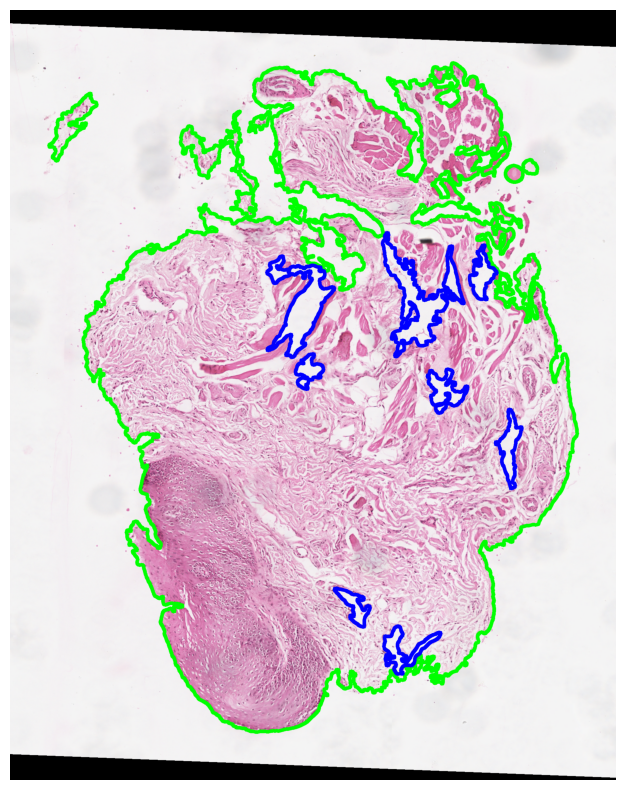

In [13]:
img_disp = he.copy()
contour_color = (0, 255, 0) # green
hole_color = (0, 0, 255) # blue
line_thickness = 10

if foreground_contours is not None:
    cv2.drawContours(img_disp, foreground_contours, -1, contour_color, line_thickness)
    for holes in hole_contours:
        cv2.drawContours(img_disp, holes, -1, hole_color, line_thickness)

out_img = Image.fromarray(img_disp)
out_img.save("segment_output.png")

plt.figure(figsize=(10, 10))
plt.imshow(out_img)
plt.axis("off")
plt.show()

## Patch extraction

In [14]:
def extract_patches(he_path, df_path, mask_path, case_id, contours, out_dir, patch_size=256, step_size=256):
    he_dir = os.path.join(out_dir, "he")
    df_dir = os.path.join(out_dir, "df")
    mask_dir = os.path.join(out_dir, "mask")
    # mask_vis_dir = os.path.join(out_dir, "mask_vis")

    # modality folder setup
    for folder in [he_dir, df_dir, mask_dir]:
        os.makedirs(folder, exist_ok=True)

    he_img = np.array(Image.open(he_path).convert("RGB"))
    df_img = np.array(Image.open(df_path).convert("RGB"))
    
    # integer class labels 0-3
    mask_img = np.array(Image.open(mask_path))
    
    H, W = he_img.shape[:2]
    assert he_img.shape == df_img.shape # H&E and df images must match in dim
    assert mask_img.shape == (H, W) # Mask must match HE/df dims

    patch_records = []
    patch_id = 0
    
    for cont in contours:
        poly = Polygon(cont.squeeze()) # shapely polygon
        min_x, min_y, max_x, max_y = poly.bounds
        
        # Grid over bounding box
        for x in range(int(min_x), int(max_x), step_size):
            for y in range(int(min_y), int(max_y), step_size):
                patch_center = Point(x + patch_size // 2, y + patch_size // 2)
                if poly.contains(patch_center): # patch fully inside tissue
                    if x + patch_size <= W and y + patch_size <= H:
                        # extractions
                        he_patch = he_img[y:y+patch_size, x:x+patch_size]
                        df_patch = df_img[y:y+patch_size, x:x+patch_size]
                        mask_patch = mask_img[y:y+patch_size, x:x+patch_size]
                        
                        # naming patch pngs
                        he_name = f"he_{patch_id}_{case_id}.png"
                        df_name = f"df_{patch_id}_{case_id}.png"
                        mask_name = f"mask_{patch_id}_{case_id}.png"
                        # mask_vis_name = f"mask_vis_{patch_id}_{case_id}.png"

                        # saving pngs
                        Image.fromarray(he_patch).save(os.path.join(he_dir, he_name))
                        Image.fromarray(df_patch).save(os.path.join(df_dir, df_name))
                        
                        #Image.fromarray(mask_patch).save(os.path.join(out_dir, "mask", case_id, mask_name))
                        Image.fromarray(mask_patch.astype(np.uint8), mode="L").save(os.path.join(mask_dir, mask_name))
                        
                        # scaling for visualization
                        # mask_vis = (mask_patch * 85).astype(np.uint8)  # 255/3 = 85 --> (0,85,170,255)
                        # Image.fromarray(mask_vis, mode="L").save(os.path.join(mask_vis_dir, mask_vis_name))

                        # loading into CSV record file
                        patch_records.append({
                            "case_id": case_id,
                            "patch_id": patch_id,
                            "x": x, "y": y,
                            "patch_size": patch_size,
                            "he_file": os.path.join("he", he_name),
                            "df_file": os.path.join("df", df_name),
                            "mask_file": os.path.join("mask", mask_name)  }) #,
                            # "mask_vis_file": os.path.join("mask_vis", mask_vis_name) })
                        
                        patch_id += 1
                    
    df = pd.DataFrame(patch_records)
    # csv_path = os.path.join(out_dir, f"{case_id}_patches.csv")
    # df.to_csv(csv_path, index=False)
    # print(f"Patch index saved to {csv_path}")

    # len(df) == patch_id
    print(f"Extracted {patch_id} paired patches for {case_id}")
    return df

In [56]:
def segment_and_extract_all(cases, out_dir,
                              patch_size=256, step_size=256,
                              sat_thresh=8, sat_thresh_up=255,
                              med_thresh=7, closing_kernel=4,
                              ref_patch_size=512,
                              filter_params={'a_t': 100, 'a_h': 16, 'max_n_holes': 8}):

    os.makedirs(out_dir, exist_ok=True)

    # clear out prev run's files
    for folder in ["he", "df", "mask"]: #"mask_vis"]:
        path = os.path.join(out_dir, folder)
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path, exist_ok=True)
        
    all_patch_records = []

    for case in cases:
        case_id = case["id"]
        he_path = case["he"]
        df_path = case["df"]
        mask_path = case["mask"]

        print(f"\nProcessing case: {case_id}")
        print(f"  HE: {he_path}")
        print(f"  DF: {df_path}")
        print(f"  Mask: {mask_path}")

        try:
            # load in H&E for this case and segment tissue
            he_img = tifffile.imread(he_path)
            if he_img.ndim == 2:  # grayscale fallback
                he_img = np.stack([he_img]*3, axis=-1)
            he_img_rgb = cv2.cvtColor(he_img, cv2.COLOR_BGR2RGB) if he_img.shape[-1] == 3 else he_img
            foreground_contours, _ = segment(
                he_img_rgb,
                sat_thresh=sat_thresh, sat_thresh_up=sat_thresh_up,
                med_thresh=med_thresh, closing_kernel=closing_kernel,
                ref_patch_size=ref_patch_size, filter_params=filter_params)

            # extract patches for current case
            df_case = extract_patches(
                he_path=he_path,
                df_path=df_path,
                mask_path=mask_path,
                case_id=case_id,
                contours=foreground_contours,
                out_dir=out_dir,
                patch_size=patch_size,
                step_size=step_size)

            all_patch_records.append(df_case)

        except Exception as e:
            print(f"ERROR: Failed for {case_id}: {e}")
            continue

    # merge all into one CSV
    if all_patch_records:
        df_all = pd.concat(all_patch_records, ignore_index=True)
        combined_csv = os.path.join(out_dir, "patches_all_cases.csv")
        df_all.to_csv(combined_csv, index=False)
        print(f"\nCombined CSV saved to: {combined_csv}")
        print(f"Total patches: {len(df_all)}")
        return df_all
    else:
        print("No patches extracted.")
        return None

In [57]:
df_all = segment_and_extract_all(cases_json, out_dir="patches_all",
                                   patch_size=256, step_size=128)



Processing case: RS_03949070
  HE: HNSCC/RS_03949070/RS_03949070/aligned/HE_IRRegistered_1um.tif
  DF: HNSCC/RS_03949070/RS_03949070/aligned/DF_IRRegistered_1um.tif
  Mask: HNSCC/RS_03949070/RS_03949070/PixelLabelData/Label_1.png
Extracted 299 paired patches for RS_03949070

Processing case: RS_03959875
  HE: HNSCC/RS_03959875/RS_03959875/aligned/HE_IRRegistered_1um.tif
  DF: HNSCC/RS_03959875/RS_03959875/aligned/DF_IRRegistered_1um.tif
  Mask: HNSCC/RS_03959875/RS_03959875/PixelLabelData/Label_1.png
Extracted 365 paired patches for RS_03959875

Processing case: RS_03959881
  HE: HNSCC/RS_03959881/RS_03959881/aligned/HE_IRRegistered_1um.tif
  DF: HNSCC/RS_03959881/RS_03959881/aligned/DF_IRRegistered_1um.tif
  Mask: HNSCC/RS_03959881/RS_03959881/PixelLabelData/Label_1.png
Extracted 116 paired patches for RS_03959881

Combined CSV saved to: patches_all/patches_all_cases.csv
Total patches: 780


#### Clearing out and deleting "patches_all" folder

In [18]:
# out_dir = "patches_all"

# if os.path.exists(out_dir):
#     shutil.rmtree(out_dir)
#     print(f"Removed existing folder: {out_dir}")

#### "patches_all" folder size sanity check

In [58]:
modalities = ["he", "df", "mask"]#, "mask_vis"]

for mod in modalities:
    folder = os.path.join("patches_all", mod)
    if os.path.exists(folder):
        n_files = len([f for f in os.listdir(folder) if f.endswith(".png")])
        print(f"{mod:<10}: {n_files} files")
    else:
        print(f"{mod:<10}: MISSING folder")


he        : 780 files
df        : 780 files
mask      : 780 files


## General training code

In [86]:
class PatchSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])
        assert len(self.img_files) == len(self.mask_files), "Mismatch between image and mask counts"

        if augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"].long()
        return image, mask

In [87]:
def get_dataloaders(img_dir, mask_dir, batch_size=8, augment=True, split_ratio=0.8):
    """Create train/val dataloaders from directory paths."""
    full_dataset = PatchSegDataset(img_dir, mask_dir, augment=augment)
    n_total = len(full_dataset)
    n_train = int(split_ratio * n_total)
    n_val = n_total - n_train
    train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader


def get_model(num_classes=4, encoder="resnet34", pretrained=True):
    """Return a pretrained UNet model."""
    weights = "imagenet" if pretrained else None
    model = smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=num_classes
    )
    return model


def dice_score(preds, targets, num_classes=4):
    """Mean Dice across all classes."""
    preds = torch.argmax(preds, dim=1)
    dice = 0
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice += (2. * intersection + 1e-6) / (union + 1e-6)
    return dice / num_classes

In [89]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4,
                num_classes=4, device=None, save_path="best_model.pth"):
    """Train UNet and save best model."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_dice = 0
    train_losses, val_losses, train_dices, val_dices = [], [], [], []

    for epoch in range(num_epochs):
        # ---- TRAIN ----
        model.train()
        train_loss, train_dice = 0, 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_dice += dice_score(outputs, masks, num_classes).item()

        train_loss /= len(train_loader)
        train_dice /= len(train_loader)

        # ---- VALIDATION ----
        model.eval()
        val_loss, val_dice = 0, 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, masks).item()
                val_dice += dice_score(outputs, masks, num_classes).item()

        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f} | "
              f"Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model (Dice={best_dice:.4f})")

    return model, (train_losses, val_losses, train_dices, val_dices)

In [106]:
def plot_training_curves(train_losses, val_losses, train_dices, val_dices, modality):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{modality.upper()} | Training & Validation Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_dices, label="Train Dice")
    plt.plot(epochs, val_dices, label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title(f"{modality.upper()} | Training & Validation Dice")
    plt.legend()
    plt.show()

In [107]:
def visualize_predictions(model, val_loader, num_classes=4, N=5, modality=""):
    cmap = plt.get_cmap("tab10", num_classes)
    device = next(model.parameters()).device
    model.eval()

    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        preds = model(imgs).argmax(dim=1).cpu()

    N = min(N, imgs.size(0))
    for i in range(N):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Input
        img_np = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        axes[0].imshow(img_np)
        axes[0].set_title(f"{modality.upper()} Input")
        axes[0].axis("off")

        # GT mask
        axes[1].imshow(masks[i].cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        # Prediction
        im = axes[2].imshow(preds[i].numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        # Colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(im, cax=cbar_ax, ticks=list(range(num_classes)))
        cbar.ax.set_yticklabels([f"Class {i}" for i in range(num_classes)])

        plt.subplots_adjust(wspace=0.05, right=0.9)
        plt.show()

## U-Net 1: DFIR

## U-Net 2: Darkfield

In [108]:
modality = "df"
root = "patches_all"
img_dir = os.path.join(root, modality)
mask_dir = os.path.join(root, "mask")
save_path = f"best_unet_{modality}.pth"

In [109]:
train_loader, val_loader = get_dataloaders(img_dir, mask_dir, batch_size=8, augment=True)

model = get_model(num_classes=4)

In [110]:
model, metrics = train_model(model, train_loader, val_loader, num_epochs=30, save_path=save_path)
train_losses, val_losses, train_dices, val_dices = metrics

Epoch [1/30] Train Loss: 1.5718, Dice: 0.1716 | Val Loss: 1.2462, Dice: 0.3359
Saved new best model (Dice=0.3359)
Epoch [2/30] Train Loss: 1.2503, Dice: 0.4243 | Val Loss: 1.0566, Dice: 0.5779
Saved new best model (Dice=0.5779)
Epoch [3/30] Train Loss: 1.0208, Dice: 0.5176 | Val Loss: 0.7740, Dice: 0.5734
Epoch [4/30] Train Loss: 0.7597, Dice: 0.5589 | Val Loss: 0.5682, Dice: 0.5970
Saved new best model (Dice=0.5970)
Epoch [5/30] Train Loss: 0.5691, Dice: 0.5561 | Val Loss: 0.4145, Dice: 0.6087
Saved new best model (Dice=0.6087)
Epoch [6/30] Train Loss: 0.4431, Dice: 0.5677 | Val Loss: 0.3347, Dice: 0.6122
Saved new best model (Dice=0.6122)
Epoch [7/30] Train Loss: 0.3460, Dice: 0.5895 | Val Loss: 0.3747, Dice: 0.5856
Epoch [8/30] Train Loss: 0.3400, Dice: 0.5727 | Val Loss: 0.2871, Dice: 0.6671
Saved new best model (Dice=0.6671)
Epoch [9/30] Train Loss: 0.2807, Dice: 0.6099 | Val Loss: 0.2293, Dice: 0.6542
Epoch [10/30] Train Loss: 0.2502, Dice: 0.6130 | Val Loss: 0.2426, Dice: 0.6570

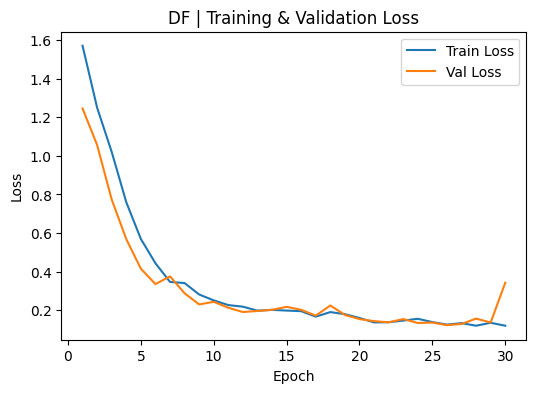

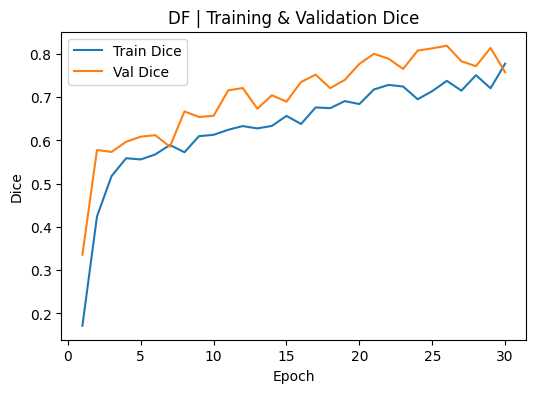

In [111]:
plot_training_curves(train_losses, val_losses, train_dices, val_dices, modality)

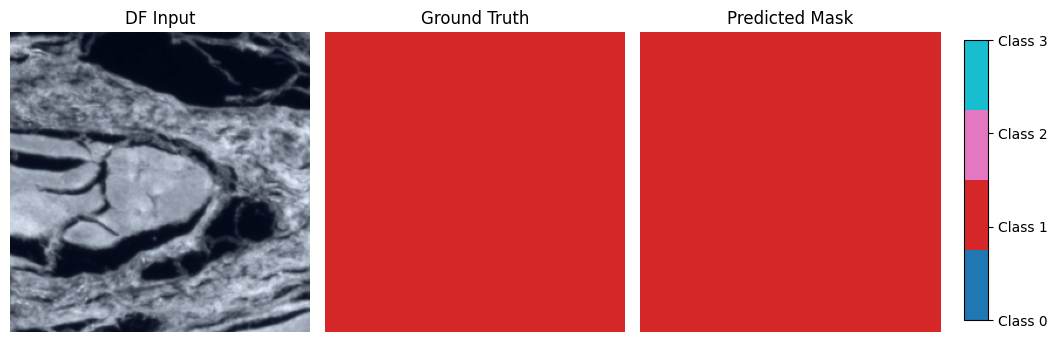

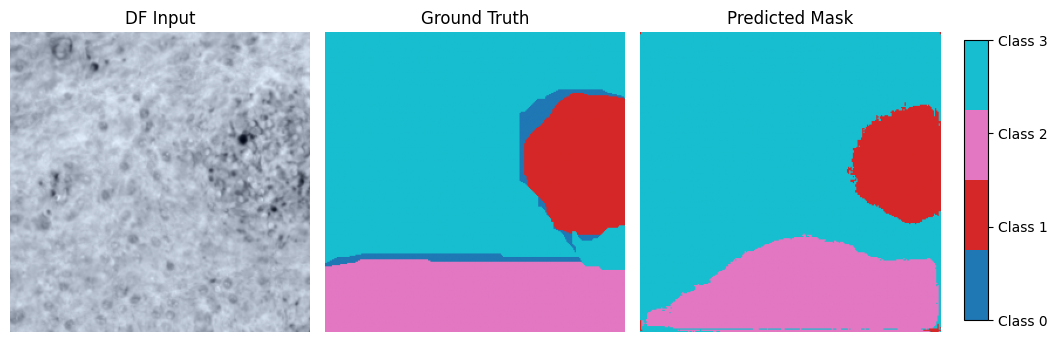

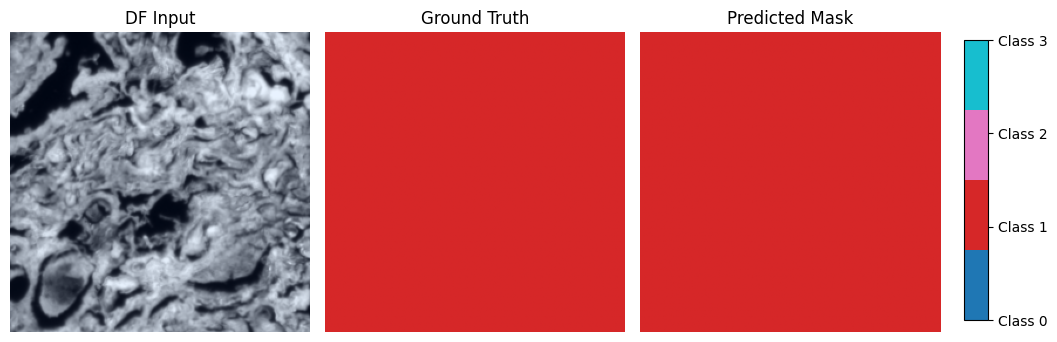

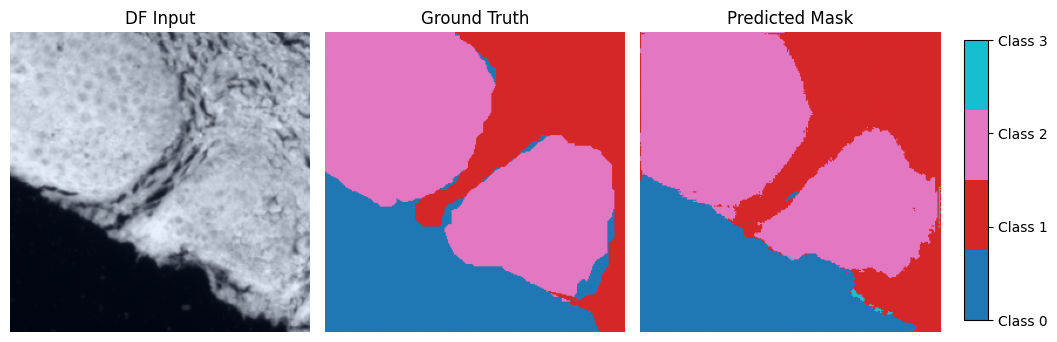

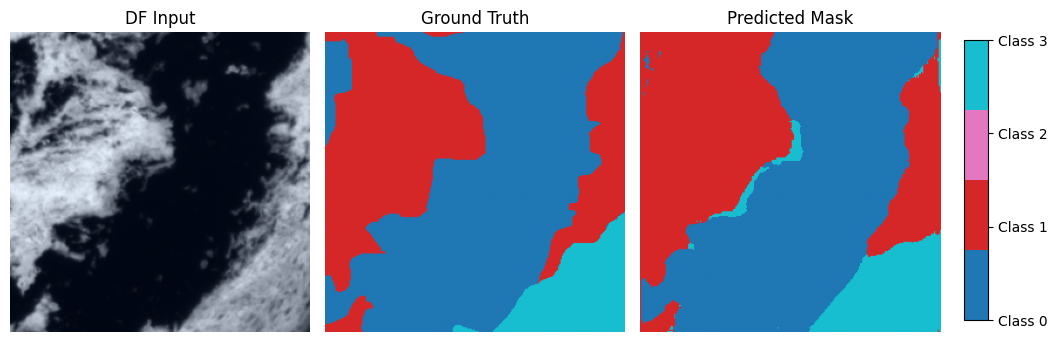

In [112]:
model.load_state_dict(torch.load(save_path))
visualize_predictions(model, val_loader, N=5, modality=modality)

### Old plots

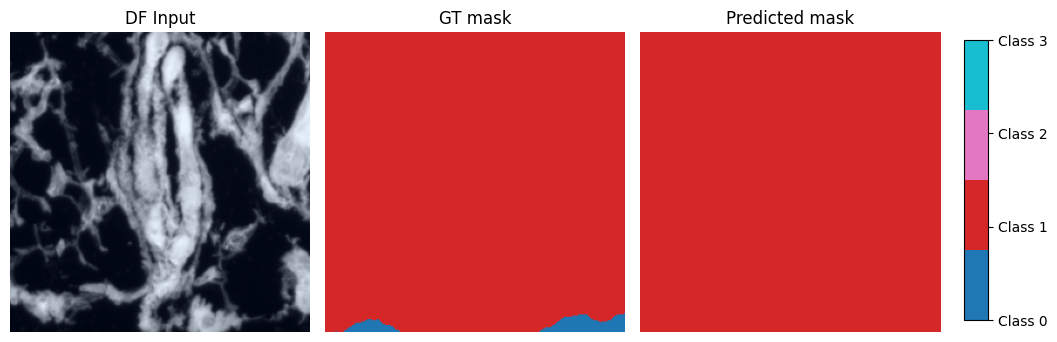

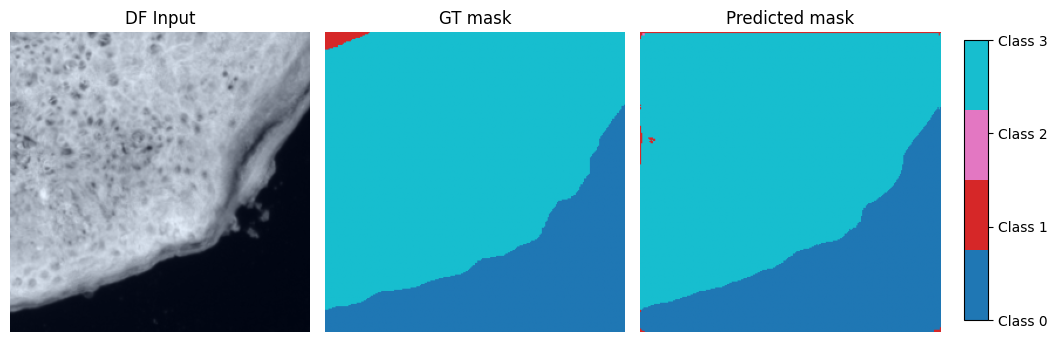

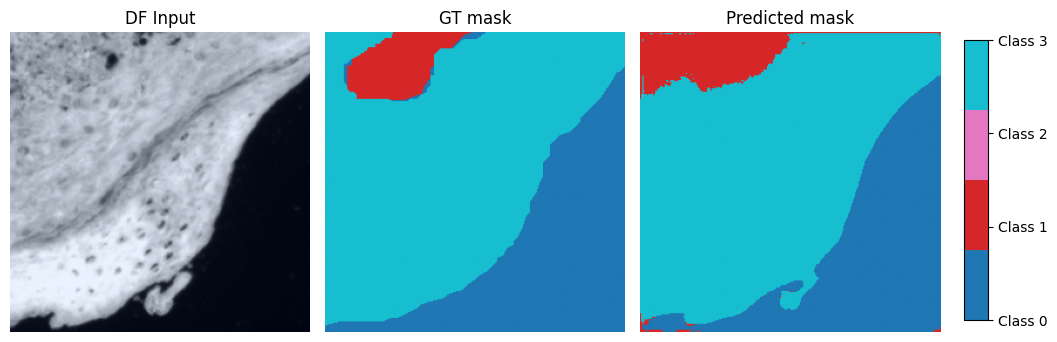

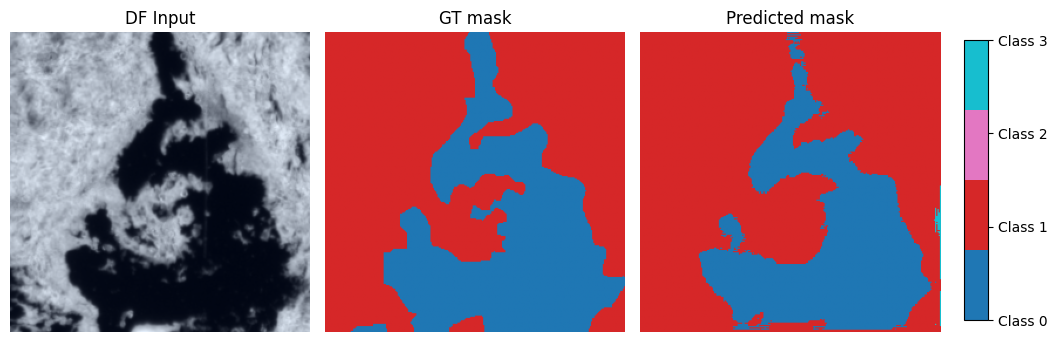

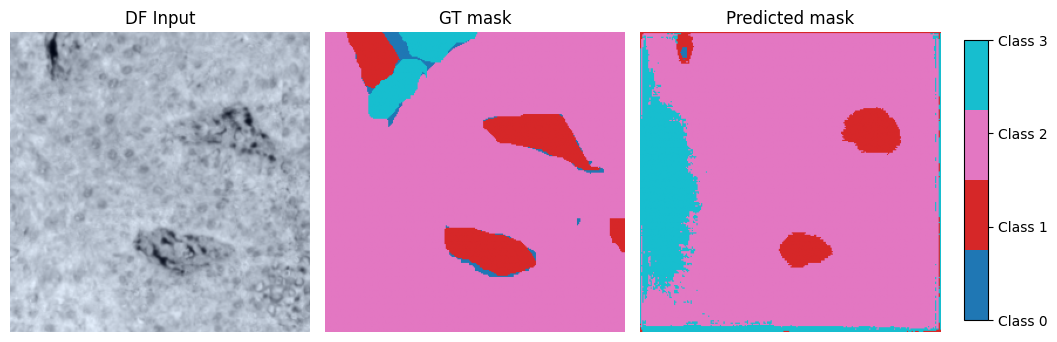

## U-Net 3: H&E

In [113]:
modality = "he"
root = "patches_all"
img_dir = os.path.join(root, modality)
mask_dir = os.path.join(root, "mask")
save_path = f"best_unet_{modality}.pth"

In [114]:
train_loader, val_loader = get_dataloaders(img_dir, mask_dir, batch_size=8, augment=True)

model = get_model(num_classes=4)

In [115]:
model, metrics = train_model(model, train_loader, val_loader, num_epochs=30, save_path=save_path)
train_losses, val_losses, train_dices, val_dices = metrics

Epoch [1/30] Train Loss: 1.1485, Dice: 0.3706 | Val Loss: 0.7590, Dice: 0.5156
Saved new best model (Dice=0.5156)
Epoch [2/30] Train Loss: 0.7166, Dice: 0.5023 | Val Loss: 0.5001, Dice: 0.5721
Saved new best model (Dice=0.5721)
Epoch [3/30] Train Loss: 0.5200, Dice: 0.5664 | Val Loss: 0.3768, Dice: 0.6527
Saved new best model (Dice=0.6527)
Epoch [4/30] Train Loss: 0.4291, Dice: 0.5676 | Val Loss: 0.2931, Dice: 0.6491
Epoch [5/30] Train Loss: 0.3705, Dice: 0.5713 | Val Loss: 0.2762, Dice: 0.6916
Saved new best model (Dice=0.6916)
Epoch [6/30] Train Loss: 0.3105, Dice: 0.6541 | Val Loss: 0.2386, Dice: 0.6914
Epoch [7/30] Train Loss: 0.3017, Dice: 0.6048 | Val Loss: 0.2278, Dice: 0.6192
Epoch [8/30] Train Loss: 0.2759, Dice: 0.6172 | Val Loss: 0.2304, Dice: 0.6470
Epoch [9/30] Train Loss: 0.2900, Dice: 0.5927 | Val Loss: 0.2126, Dice: 0.6711
Epoch [10/30] Train Loss: 0.2625, Dice: 0.6192 | Val Loss: 0.2330, Dice: 0.6517
Epoch [11/30] Train Loss: 0.2740, Dice: 0.6216 | Val Loss: 0.1918, Di

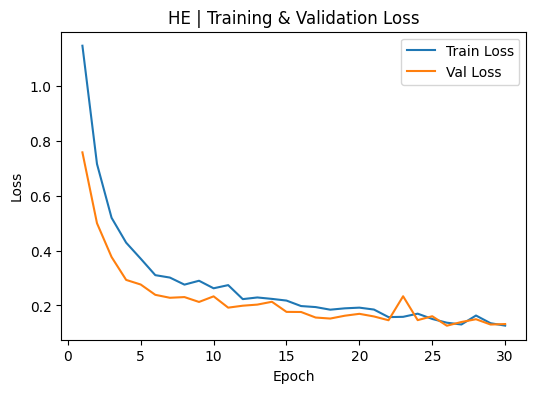

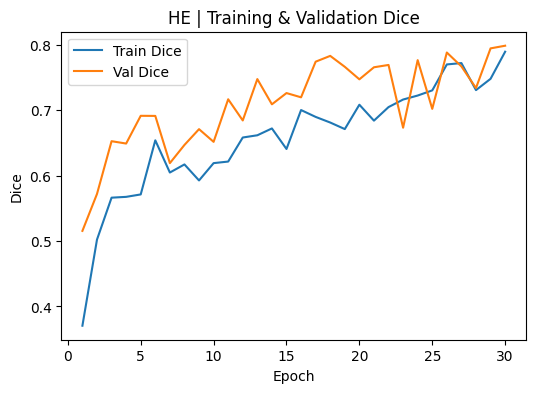

In [116]:
plot_training_curves(train_losses, val_losses, train_dices, val_dices, modality)

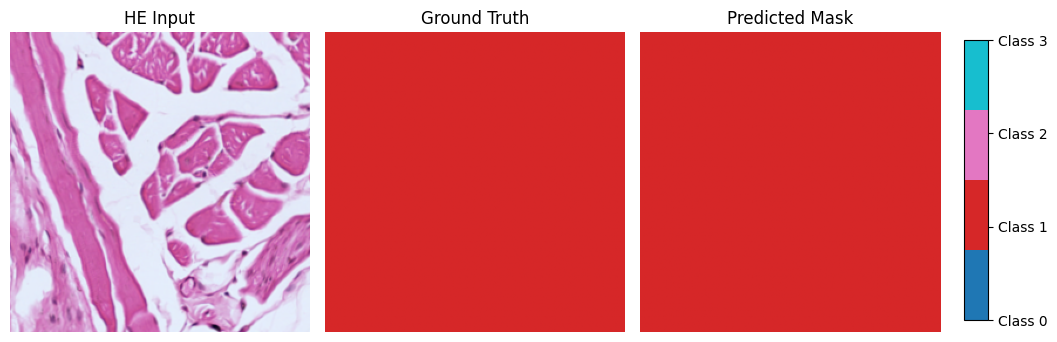

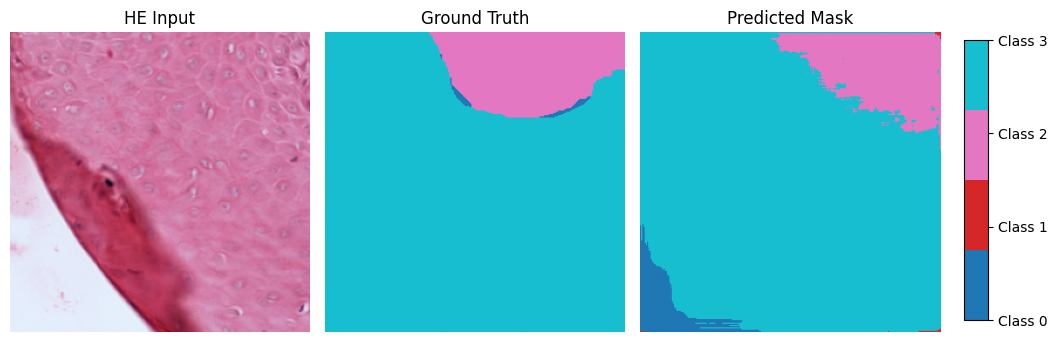

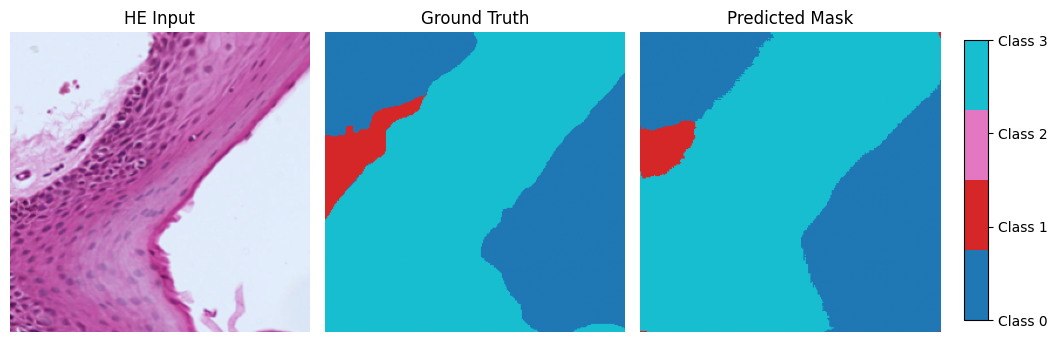

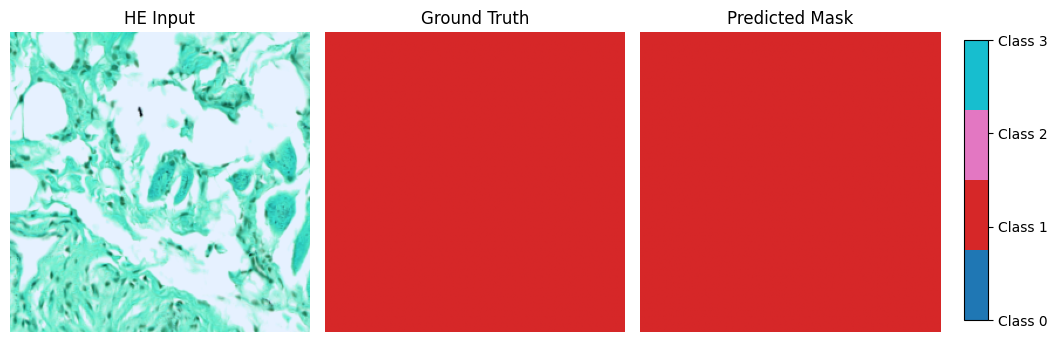

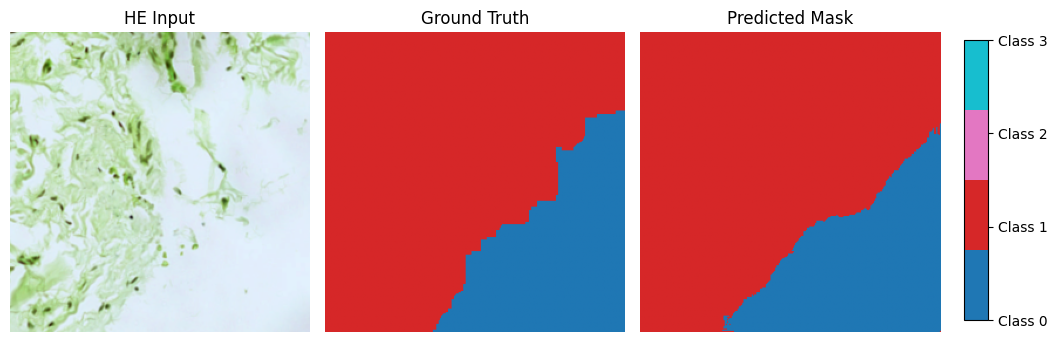

In [117]:
model.load_state_dict(torch.load(save_path))
visualize_predictions(model, val_loader, N=5, modality=modality)

In [118]:
!pip freeze > requirements.txt